# Growth curves nitrogen sources

## Load packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import numpy as np
import seaborn as sns

## Specify filepaths

In [5]:
source_plate = 'data/20210408_plate.xlsx'
plate_data = 'data/20210411_cyto_as_nitro.xlsx'
graph_outpath = 'graphs/'

In [6]:
plate_df = pd.read_excel(source_plate, header=0)
plate_df.head(6)

,well,compound,concentration,strain,replicate
0,A1,cytosine,1.0,LL13-040,1
1,A2,cytosine,1.0,LL13-040,2
2,A3,cytosine,1.0,LL13-040,3
3,A4,cytosine,1.0,NC-02,1
4,A5,cytosine,1.0,NC-02,2
5,A6,cytosine,1.0,NC-02,3


## Get plate reader data

In [7]:
def get_data(fpath):
    source_df = pd.read_excel(fpath, header=1, index_col=0,skiprows=[2],
                              #skipfooter=34
                             )
    source_df.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)
    longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD') # wide to long dataframe
    return longdf

In [8]:
df = get_data(plate_data)
df.head(6)

,well,time (h),OD
0,A1,0.0,0.094750
1,A2,0.0,0.095325
2,A3,0.0,0.095500
3,A4,0.0,0.096725
4,A5,0.0,0.096800
5,A6,0.0,0.098125


In [9]:
merged = df.merge(right=plate_df, on=['well'])
merged.head(6)

,well,time (h),OD,compound,concentration,strain,replicate
0,A1,0.0,0.094750,cytosine,1.0,LL13-040,1
1,A1,0.25,0.095900,cytosine,1.0,LL13-040,1
2,A1,0.5,0.097025,cytosine,1.0,LL13-040,1
3,A1,0.75,0.097875,cytosine,1.0,LL13-040,1
4,A1,1.0,0.098800,cytosine,1.0,LL13-040,1
5,A1,1.250278,0.099750,cytosine,1.0,LL13-040,1


## Growth curves

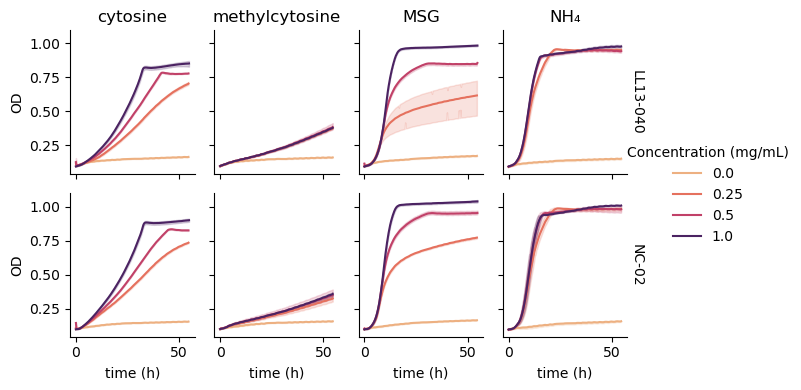

In [11]:
compound_order = ['cytosine', 'methylcytosine', 'MSG', 'NH4']
grid = sns.relplot(data=merged, x='time (h)', y='OD',
                   col='compound', col_order=compound_order, row='strain',
                   hue='concentration', palette='flare',
                   kind='line',
                   height=2, aspect=0.87,
                   facet_kws = {'margin_titles': True, 'legend_out':True}
                  )

compound_labels = ['cytosine', 'methylcytosine', 'MSG', 'NH₄']
grid.set_titles(row_template='{row_name}')
for i, v in enumerate(compound_order):
    grid.axes[0][i].set_title(compound_labels[i]) # Note: not the same font size as classic set_titles

grid._legend.set_title('Concentration (mg/mL)')
grid.tight_layout()
plt.savefig(graph_outpath+'20230411_growth_cytosine.png', format='png', dpi=300)
plt.savefig(graph_outpath+'20230411_growth_cytosine.svg', format='svg', dpi=300)

## AUC

In [8]:
def get_auc(g):
    return np.trapz(g.OD)

In [9]:
aucdf = merged[merged['time (h)'] > 0.2].groupby(['medium','concentration','well'])[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf.head(6)

,medium,concentration,well,auc
0,SC_complete,0.00,B10,198.069695
1,SC_complete,0.00,B11,200.126060
2,SC_complete,0.00,B9,199.334395
3,SC_complete,1.56,B6,184.173920
4,SC_complete,1.56,B7,178.166645
5,SC_complete,1.56,B8,177.439730


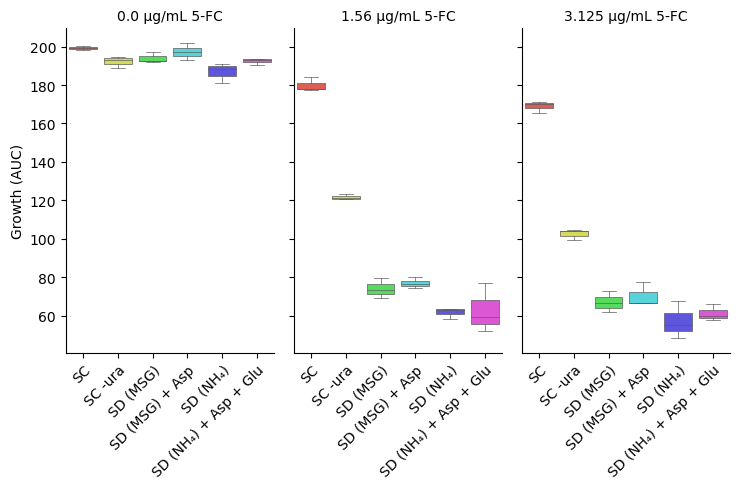

In [10]:
grid = sns.catplot(data=aucdf, x='medium', order=['SC_complete', 'SC_ura', 'SD_MSG', 'SD_MSG_Asp', 'SD_NH4', 'SD_NH4_Asp_Glu'],
                   y='auc', col='concentration',
                   hue='medium', palette='hls', saturation=1,
                   kind='box', dodge=False,
                   linewidth=0.5,
                   height=5, aspect=0.5
                  )

grid.set_titles(col_template='{col_name} μg/mL 5-FC')
grid.set_axis_labels('', 'Growth (AUC)')
for i in range(len(aucdf.concentration.unique())):
    grid.axes[0][i].set_xticklabels(['SC', 'SC -ura', 'SD (MSG)', 'SD (MSG) + Asp', 'SD (NH₄)', 'SD (NH₄) + Asp + Glu'],
                                    rotation=45, ha='right', rotation_mode='anchor')

grid.tight_layout()
plt.savefig(graph_outpath+'20230403_5FC_defined_medium.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230403_5FC_defined_medium.png', format='png', dpi=300)